In [188]:
# 필요한 라이브러리 임포트&설치
# !pip install dbfread
# !pip install haversine
# !pip install sklearn
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine
from tqdm.notebook import tqdm
%matplotlib inline
import platform
import pickle
import re
platform.system()
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'

In [189]:
def csv(route):
    k = pd.read_csv('{}'.format(route),encoding='cp949')
    k = k.rename(columns=k.iloc[0]).drop(k.index[0])
    return k

In [190]:
def pklopen(route):
    with open('./가공한데이터/{}'.format(route), 'rb') as f:
        df = pickle.load(f)
    return df
def pklsave(df, name):
    with open('{}.pkl'.format(name), 'wb') as f:
        pickle.dump(df, f)

In [191]:
#행정구/동 매칭
dong = pd.read_excel('./data/서울시_행정동_법정동_20200814.xlsx')
#행정동별 거주인구
dong_pop = pklopen('행정동별_거주인구_성별_연령.pickle')
#2015년 결혼상태
married_rate = pd.read_csv('./data/서울시 혼인상태별 인구(15세 이상) 통계.txt', sep='\t')
#행정동별 세대수
dong_family = pd.read_csv('./data/행정동별 세대수(17년 12월).txt', sep='\t')
#행정동별 전체인구수
total_ppl = pd.read_pickle('./data/행정동별 전체 인구.pkl')

# 전처리

In [192]:
#동별 코드/구/읍면동명(행정동명)자료
dong = dong[dong['시도명']=='서울특별시']
dong_df = dong[['행정동코드','시군구명']].dropna().drop_duplicates()
dong_df['행정동코드'] = dong_df['행정동코드'].astype(str)
# dong_df.columns = ['행정동코드','시군구명','읍면동명']
dong_df

,행정동코드,시군구명
1,1111000000,종로구
2,1111051500,종로구
12,1111053000,종로구
24,1111054000,종로구
31,1111055000,종로구
...,...,...
763,1174065000,강동구
764,1174066000,강동구
765,1174068500,강동구
766,1174069000,강동구


In [193]:
dong_pop

,ADMI_CD,ADMI_NM,5559세_2,5559세_1,5054세_1,5054세_2,4549세_1,4549세_2,4044세_1,4044세_2,...,2529세_1,2529세_2,2024세_1,2024세_2,1519세_1,1519세_2,1014세_1,1014세_2,0509세_2,0509세_1
1725910,1117051000,후암동,757,709,722,763,745,782,601,653,...,783,748,540,524,422,330,310,270,266,299
1725912,1159053000,상도1동,1691,1439,1535,1723,1716,1678,1616,1657,...,2631,2201,2346,2649,977,908,792,773,839,880
1725913,1111070000,숭인1동,288,305,254,293,292,258,216,202,...,228,225,184,179,102,114,85,92,94,98
1725917,1111061500,종로1.2.3.4가동,251,549,431,164,341,218,242,157,...,308,212,142,195,59,66,58,41,46,54
1725919,1117057000,원효로2동,547,586,569,634,633,640,530,576,...,501,530,385,471,292,440,230,341,267,271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728432,1153059500,가리봉동,425,592,589,369,411,338,284,210,...,498,368,257,283,96,99,72,56,65,74
1728436,1156055000,당산1동,783,774,783,756,799,718,754,701,...,1087,1256,552,708,300,301,220,212,274,253
1728438,1141072000,북가좌2동,1486,1272,1390,1399,1383,1438,1147,1191,...,1373,1310,1116,1110,768,726,544,525,477,547
1728439,1165062000,방배3동,1024,856,838,916,852,1027,686,786,...,805,720,714,688,666,547,393,460,368,396


In [194]:
#동별 타겟나이 전처리
dong_pop.reset_index(inplace=True)
del dong_pop['index']
dong_pop.columns = ['행정동코드', '행정동명', '5559세_(여)', '5559세_(남)', '5054세_(남)', '5054세_(여)',
       '4549세_(남)', '4549세_(여)', '4044세_(남)', '4044세_(여)', '3539세_(남)', '3539세_(여)',
       '3034세_(남)', '3034세_(여)', '2529세_(남)', '2529세_(여)', '2024세_(남)', '2024세_(여)',
       '1519세_(남)', '1519세_(여)', '1014세_(남)', '1014세_(여)', '0509세_(여)', '0509세_(남)']
dong_pop['0514세 인구'] = dong_pop['0509세_(남)'] + dong_pop['0509세_(여)'] + dong_pop['1014세_(남)']+dong_pop['1014세_(여)']
dong_pop['30대 인구'] = dong_pop['3034세_(남)'] + dong_pop['3034세_(여)'] + dong_pop['3539세_(남)'] + dong_pop['3539세_(여)']
dong_pop['40대 인구'] = dong_pop['4044세_(남)'] + dong_pop['4044세_(여)'] + dong_pop['4549세_(남)'] + dong_pop['4549세_(여)']

dong_pop = dong_pop.replace({'행정동명': '종로5.6가동'}, {'행정동명': '종로5·6가동'})

dong_pop

,행정동코드,행정동명,5559세_(여),5559세_(남),5054세_(남),5054세_(여),4549세_(남),4549세_(여),4044세_(남),4044세_(여),...,2024세_(여),1519세_(남),1519세_(여),1014세_(남),1014세_(여),0509세_(여),0509세_(남),0514세 인구,30대 인구,40대 인구
0,1117051000,후암동,757,709,722,763,745,782,601,653,...,524,422,330,310,270,266,299,1145,2846,2781
1,1159053000,상도1동,1691,1439,1535,1723,1716,1678,1616,1657,...,2649,977,908,792,773,839,880,3284,6458,6667
2,1111070000,숭인1동,288,305,254,293,292,258,216,202,...,179,102,114,85,92,94,98,369,845,968
3,1111061500,종로1.2.3.4가동,251,549,431,164,341,218,242,157,...,195,59,66,58,41,46,54,199,905,958
4,1117057000,원효로2동,547,586,569,634,633,640,530,576,...,471,292,440,230,341,267,271,1109,2087,2379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1153059500,가리봉동,425,592,589,369,411,338,284,210,...,283,96,99,72,56,65,74,267,1219,1243
420,1156055000,당산1동,783,774,783,756,799,718,754,701,...,708,300,301,220,212,274,253,959,4228,2972
421,1141072000,북가좌2동,1486,1272,1390,1399,1383,1438,1147,1191,...,1110,768,726,544,525,477,547,2093,4444,5159
422,1165062000,방배3동,1024,856,838,916,852,1027,686,786,...,688,666,547,393,460,368,396,1617,3049,3351


In [195]:
#동별 타겟나이 필요분만 추리기
dong_pop_need = dong_pop[['행정동코드','행정동명','0514세 인구','30대 인구','40대 인구']]
dong_pop_need['행정동코드']=dong_pop_need['행정동코드'].astype(str)
dong_pop_need['0514세 인구']=dong_pop_need['0514세 인구'].astype(int)
dong_pop_need['30대 인구']=dong_pop_need['30대 인구'].astype(int)
dong_pop_need['40대 인구']=dong_pop_need['40대 인구'].astype(int)
dong_pop_need['3040세 인구'] = dong_pop_need['30대 인구'] + dong_pop_need['40대 인구']

del dong_pop_need['30대 인구']
del dong_pop_need['40대 인구']

pop_df = pd.merge(dong_pop_need, dong_df, on='행정동코드')
pop_df

<ipython-input-195-89af5f5390e9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_pop_need['행정동코드']=dong_pop_need['행정동코드'].astype(str)
<ipython-input-195-89af5f5390e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_pop_need['0514세 인구']=dong_pop_need['0514세 인구'].astype(int)
<ipython-input-195-89af5f5390e9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

,행정동코드,행정동명,0514세 인구,3040세 인구,시군구명
0,1117051000,후암동,1145,5627,용산구
1,1159053000,상도1동,3284,13125,동작구
2,1111070000,숭인1동,369,1813,종로구
3,1111061500,종로1.2.3.4가동,199,1863,종로구
4,1117057000,원효로2동,1109,4466,용산구
...,...,...,...,...,...
419,1153059500,가리봉동,267,2462,구로구
420,1156055000,당산1동,959,7200,영등포구
421,1141072000,북가좌2동,2093,9603,서대문구
422,1165062000,방배3동,1617,6400,서초구


In [196]:
#결혼율 전처리
married_rate = married_rate.rename(columns=married_rate.iloc[1]).drop(married_rate.index[:2])
married_rate_need = married_rate.iloc[:, :7]
del married_rate_need['기간']
married_rate_need.계 = married_rate_need.계.apply(lambda x: re.sub(',','', x))#.astype(int)
married_rate_need.유배우 = married_rate_need.유배우.apply(lambda x: re.sub(',','', x))#.astype(int)
married_rate_need.사별 = married_rate_need.사별.apply(lambda x: re.sub(',','', x))#.astype(int)
married_rate_need.이혼 = married_rate_need.이혼.apply(lambda x: re.sub(',','', x))#.astype(int)

married_rate_need.계 = married_rate_need.계.apply(lambda x: re.sub('-','0', x)).astype(int)
married_rate_need.유배우 = married_rate_need.유배우.apply(lambda x: re.sub('-','0', x)).astype(int)
married_rate_need.사별 = married_rate_need.사별.apply(lambda x: re.sub('-','0', x)).astype(int)
married_rate_need.이혼 = married_rate_need.이혼.apply(lambda x: re.sub('-','0', x)).astype(int)

married_rate_need

C:\anaconda3\lib\site-packages\pandas\core\generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,자치구,연령별,계,유배우,사별,이혼
2,합계,합계,8393832,4481669,519388,417869
3,합계,15~19,543220,305,83,17
4,합계,20~24,681323,6832,243,397
5,합계,25~29,721164,76824,200,1490
6,합계,30~34,821484,352439,403,7422
...,...,...,...,...,...,...
413,강동구,65~69,19697,15001,3021,1473
414,강동구,70~74,13382,9120,3359,740
415,강동구,75~79,8294,4568,3338,302
416,강동구,80~84,4802,1726,2885,147


In [197]:
#구별 결혼율
age30=married_rate_need['연령별'] == '30~34'
age35=married_rate_need['연령별'] == '35~39'
age40=married_rate_need['연령별'] == '40~44'
age45=married_rate_need['연령별'] == '45~49'
age_need = pd.concat([married_rate_need[age30].iloc[:,0].reset_index(), married_rate_need[age30].iloc[:,2:].reset_index() + married_rate_need[age35].iloc[:,2:].reset_index() + married_rate_need[age40].iloc[:,2:].reset_index() + married_rate_need[age45].iloc[:,2:].reset_index()], axis=1)
del age_need['index']
age_need['결혼율'] = 100*(age_need['유배우']/age_need['계']).round(4)
married_rate_gu_df = age_need[['자치구','결혼율']]
married_rate_gu_df.columns = ['시군구명','3040대 결혼율']
married_rate_gu_df

,시군구명,3040대 결혼율
0,합계,63.46
1,종로구,58.89
2,중구,55.72
3,용산구,59.37
4,성동구,62.81
5,광진구,59.39
6,동대문구,60.47
7,중랑구,59.82
8,성북구,66.26
9,강북구,57.55


In [198]:
pop_df

,행정동코드,행정동명,0514세 인구,3040세 인구,시군구명
0,1117051000,후암동,1145,5627,용산구
1,1159053000,상도1동,3284,13125,동작구
2,1111070000,숭인1동,369,1813,종로구
3,1111061500,종로1.2.3.4가동,199,1863,종로구
4,1117057000,원효로2동,1109,4466,용산구
...,...,...,...,...,...
419,1153059500,가리봉동,267,2462,구로구
420,1156055000,당산1동,959,7200,영등포구
421,1141072000,북가좌2동,2093,9603,서대문구
422,1165062000,방배3동,1617,6400,서초구


In [199]:
#동별 2인이상 가구 전체 수
dong_family_need = dong_family[['행정동','자치구','전체세대수','1인세대']]
dong_family_need['전체세대수'] = pd.to_numeric(dong_family_need['전체세대수'].apply(lambda x: re.sub(',','', x)))
dong_family_need['1인세대'] = pd.to_numeric(dong_family_need['1인세대'].apply(lambda x: re.sub(',','', x)))
dong_family_need['2인이상세대'] = dong_family_need['전체세대수']-dong_family_need['1인세대']
# dong_family_need['2인이상세대'] = dong_family_need['전체세대수']-dong_family_need['1인세대']
dong_family_df = dong_family_need[dong_family_need.행정동 !='소계']
dong_family_df = dong_family_df[dong_family_df.행정동 !='합계']
dong_family_df.columns = ['행정동명','시군구명','전체세대수','1인세대수','2인이상세대수']

total_df = pd.merge(dong_family_df, pop_df, on = ['행정동명','시군구명'])
total_df['행정동코드'] = total_df['행정동코드'].astype(str)
total_df.reset_index(inplace=True)
del total_df['index']
total_df.dropna()

<ipython-input-199-fbe8edb47df6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_family_need['전체세대수'] = pd.to_numeric(dong_family_need['전체세대수'].apply(lambda x: re.sub(',','', x)))
<ipython-input-199-fbe8edb47df6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_family_need['1인세대'] = pd.to_numeric(dong_family_need['1인세대'].apply(lambda x: re.sub(',','', x)))
<ipython-input-199-fbe8edb47df6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,행정동명,시군구명,전체세대수,1인세대수,2인이상세대수,행정동코드,0514세 인구,3040세 인구
0,사직동,종로구,4414,2061,2353,1111053000,704,2903
1,삼청동,종로구,1414,721,693,1111054000,165,748
2,부암동,종로구,4325,1623,2702,1111055000,815,2884
3,평창동,종로구,7510,2393,5117,1111056000,1413,5063
4,무악동,종로구,3024,708,2316,1111057000,925,2558
...,...,...,...,...,...,...,...,...
419,둔촌1동,강동구,888,382,506,1174069000,11,78
420,둔촌2동,강동구,11126,3249,7877,1174070000,2049,8081
421,암사1동,강동구,16345,6031,10314,1174057000,2453,11243
422,천호2동,강동구,17305,7991,9314,1174061000,1710,11353


In [200]:
total_ppl.columns = ['행정동코드','행정동명','시군구명','총거주인구']
total_ppl['행정동코드'] = total_ppl['행정동코드'] + '00'
total_ppl.reset_index(inplace=True)
del total_ppl['index']

total_ppl = total_ppl.replace({'행정동명': '종로5.6가동'}, {'행정동명': '종로5·6가동'})

total_ppl[total_ppl.행정동명=='종로5·6가동']

,행정동코드,행정동명,시군구명,총거주인구
221,1111063000,종로5·6가동,종로구,5340


In [201]:
whole_df = pd.merge(total_df, total_ppl, on=['행정동명','시군구명','행정동코드'])
whole_df = whole_df[['행정동코드','시군구명','행정동명','0514세 인구','3040세 인구','2인이상세대수','총거주인구']]
final_df = pd.merge(whole_df, married_rate_gu_df, on='시군구명')
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,2인이상세대수,총거주인구,3040대 결혼율
0,1111053000,종로구,사직동,704,2903,2353,9481,58.89
1,1111054000,종로구,삼청동,165,748,693,2718,58.89
2,1111055000,종로구,부암동,815,2884,2702,10093,58.89
3,1111056000,종로구,평창동,1413,5063,5117,18523,58.89
4,1111057000,종로구,무악동,925,2558,2316,8684,58.89
...,...,...,...,...,...,...,...,...
419,1174069000,강동구,둔촌1동,11,78,506,263,65.26
420,1174070000,강동구,둔촌2동,2049,8081,7877,27214,65.26
421,1174057000,강동구,암사1동,2453,11243,10314,35974,65.26
422,1174061000,강동구,천호2동,1710,11353,9314,34852,65.26


# 결혼율과 3~40대 인구 곱 

In [202]:
final_df['3040세 기혼인구'] = ((final_df['3040세 인구'] * final_df['3040대 결혼율'])/100).round(0)
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,2인이상세대수,총거주인구,3040대 결혼율,3040세 기혼인구
0,1111053000,종로구,사직동,704,2903,2353,9481,58.89,1710.0
1,1111054000,종로구,삼청동,165,748,693,2718,58.89,440.0
2,1111055000,종로구,부암동,815,2884,2702,10093,58.89,1698.0
3,1111056000,종로구,평창동,1413,5063,5117,18523,58.89,2982.0
4,1111057000,종로구,무악동,925,2558,2316,8684,58.89,1506.0
...,...,...,...,...,...,...,...,...,...
419,1174069000,강동구,둔촌1동,11,78,506,263,65.26,51.0
420,1174070000,강동구,둔촌2동,2049,8081,7877,27214,65.26,5274.0
421,1174057000,강동구,암사1동,2453,11243,10314,35974,65.26,7337.0
422,1174061000,강동구,천호2동,1710,11353,9314,34852,65.26,7409.0


In [203]:
final_df['3040세 세대별 기혼비율지수(기혼인구/2인이상세대수)'] = 100*(final_df['3040세 기혼인구']/final_df['2인이상세대수']).round(2)
final_df['3040세 인구별 기혼비율(기혼인구/총거주인구)'] = 100*(final_df['3040세 기혼인구']/final_df['총거주인구']).round(2)
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,2인이상세대수,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 세대별 기혼비율지수(기혼인구/2인이상세대수),3040세 인구별 기혼비율(기혼인구/총거주인구)
0,1111053000,종로구,사직동,704,2903,2353,9481,58.89,1710.0,73.0,18.0
1,1111054000,종로구,삼청동,165,748,693,2718,58.89,440.0,63.0,16.0
2,1111055000,종로구,부암동,815,2884,2702,10093,58.89,1698.0,63.0,17.0
3,1111056000,종로구,평창동,1413,5063,5117,18523,58.89,2982.0,58.0,16.0
4,1111057000,종로구,무악동,925,2558,2316,8684,58.89,1506.0,65.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...
419,1174069000,강동구,둔촌1동,11,78,506,263,65.26,51.0,10.0,19.0
420,1174070000,강동구,둔촌2동,2049,8081,7877,27214,65.26,5274.0,67.0,19.0
421,1174057000,강동구,암사1동,2453,11243,10314,35974,65.26,7337.0,71.0,20.0
422,1174061000,강동구,천호2동,1710,11353,9314,34852,65.26,7409.0,80.0,21.0


In [206]:
final_df['초등돌봄필요지수(세대별)']=final_df['3040세 세대별 기혼비율지수(기혼인구/2인이상세대수)']*final_df['0514세 인구']
final_df['초등돌봄필요지수(인구별)']=final_df['3040세 인구별 기혼비율(기혼인구/총거주인구)']*final_df['0514세 인구']
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,2인이상세대수,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 세대별 기혼비율지수(기혼인구/2인이상세대수),3040세 인구별 기혼비율(기혼인구/총거주인구),초등돌봄필요지수(세대별),초등돌봄필요지수(인구별)
0,1111053000,종로구,사직동,704,2903,2353,9481,58.89,1710.0,73.0,18.0,51392.0,12672.0
1,1111054000,종로구,삼청동,165,748,693,2718,58.89,440.0,63.0,16.0,10395.0,2640.0
2,1111055000,종로구,부암동,815,2884,2702,10093,58.89,1698.0,63.0,17.0,51345.0,13855.0
3,1111056000,종로구,평창동,1413,5063,5117,18523,58.89,2982.0,58.0,16.0,81954.0,22608.0
4,1111057000,종로구,무악동,925,2558,2316,8684,58.89,1506.0,65.0,17.0,60125.0,15725.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1174069000,강동구,둔촌1동,11,78,506,263,65.26,51.0,10.0,19.0,110.0,209.0
420,1174070000,강동구,둔촌2동,2049,8081,7877,27214,65.26,5274.0,67.0,19.0,137283.0,38931.0
421,1174057000,강동구,암사1동,2453,11243,10314,35974,65.26,7337.0,71.0,20.0,174163.0,49060.0
422,1174061000,강동구,천호2동,1710,11353,9314,34852,65.26,7409.0,80.0,21.0,136800.0,35910.0


In [207]:
final_df.corr()

,0514세 인구,3040세 인구,2인이상세대수,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 세대별 기혼비율지수(기혼인구/2인이상세대수),3040세 인구별 기혼비율(기혼인구/총거주인구),초등돌봄필요지수(세대별),초등돌봄필요지수(인구별)
0514세 인구,1.000000,0.779563,0.777089,0.785840,0.363173,0.802369,0.063288,0.390233,0.267490,0.983057
3040세 인구,0.779563,1.000000,0.883273,0.968274,0.242978,0.985304,0.078630,0.483471,0.221810,0.773668
2인이상세대수,0.777089,0.883273,1.000000,0.943697,0.299414,0.882721,-0.125259,0.248017,0.039239,0.725847
총거주인구,0.785840,0.968274,0.943697,1.000000,0.248125,0.953928,0.042836,0.312623,0.195235,0.745174
3040대 결혼율,0.363173,0.242978,0.299414,0.248125,1.000000,0.393017,0.067486,0.598826,0.136109,0.428431
3040세 기혼인구,0.802369,0.985304,0.882721,0.953928,0.393017,1.000000,0.088438,0.559671,0.236235,0.811403
3040세 세대별 기혼비율지수(기혼인구/2인이상세대수),0.063288,0.078630,-0.125259,0.042836,0.067486,0.088438,1.000000,0.156702,0.975967,0.090215
3040세 인구별 기혼비율(기혼인구/총거주인구),0.390233,0.483471,0.248017,0.312623,0.598826,0.559671,0.156702,1.000000,0.201813,0.515521
초등돌봄필요지수(세대별),0.267490,0.221810,0.039239,0.195235,0.136109,0.236235,0.975967,0.201813,1.000000,0.287643
초등돌봄필요지수(인구별),0.983057,0.773668,0.725847,0.745174,0.428431,0.811403,0.090215,0.515521,0.287643,1.000000


<AxesSubplot:>

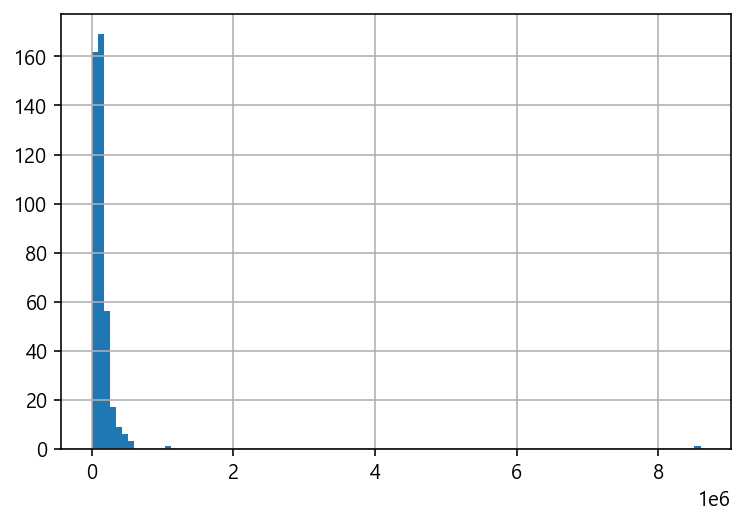

In [210]:
final_df['초등돌봄필요지수(세대별)'].hist(bins=100)

<AxesSubplot:>

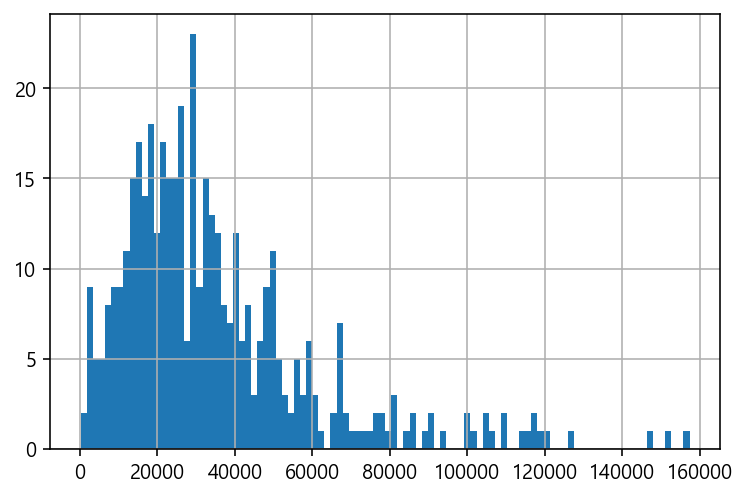

In [209]:
final_df['초등돌봄필요지수(인구별)'].hist(bins=100)

{'whiskers': [<matplotlib.lines.Line2D at 0x15f401986a0>,
 'caps': [<matplotlib.lines.Line2D at 0x15f40198d60>,
 'boxes': [<matplotlib.lines.Line2D at 0x15f40198340>],
 'medians': [<matplotlib.lines.Line2D at 0x15f4019c460>],
 'fliers': [<matplotlib.lines.Line2D at 0x15f4019c7c0>],
 'means': []}

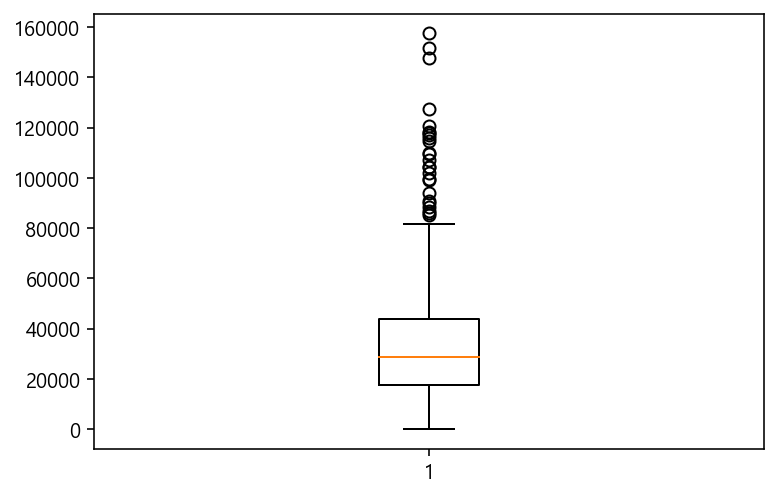

In [211]:
plt.boxplot(final_df['초등돌봄필요지수(인구별)'])

In [213]:
final_df.sort_values(by='초등돌봄필요지수(인구별)',ascending=False)

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,2인이상세대수,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 세대별 기혼비율지수(기혼인구/2인이상세대수),3040세 인구별 기혼비율(기혼인구/총거주인구),초등돌봄필요지수(세대별),초등돌봄필요지수(인구별)
404,1171067000,송파구,잠실2동,6297,13331,10098,36636,67.50,8998.0,89.0,25.0,560433.0,157425.0
238,1147055000,양천구,목5동,6591,13560,11969,42628,71.04,9633.0,80.0,23.0,527280.0,151593.0
188,1138069000,은평구,진관동,7384,18196,14763,57622,63.29,11516.0,78.0,20.0,575952.0,147680.0
118,1129066000,성북구,길음1동,5305,13021,10398,36678,66.26,8628.0,83.0,24.0,440315.0,127320.0
399,1171064700,송파구,위례동,4636,10760,7829,28258,67.50,7263.0,93.0,26.0,431148.0,120536.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,1111067000,종로구,창신1동,174,1192,1272,5164,58.89,702.0,55.0,14.0,9570.0,2436.0
8,1111063000,종로구,종로5·6가동,146,1333,1110,5340,58.89,785.0,71.0,15.0,10366.0,2190.0
19,1114055000,중구,명동,124,841,505,2999,55.72,469.0,93.0,16.0,11532.0,1984.0
23,1114060500,중구,을지로동,44,481,247,1830,55.72,268.0,109.0,15.0,4796.0,660.0


# pt 하기

In [213]:
pt_list = np.percentile(total_df[['틈새수요지수(3040세 기혼인구 * 0514세 인구)']],[i*10 for i in range(1,11)]).tolist()
pt_list

[1303366.1,
 2708420.4000000004,
 3779507.8999999994,
 5120062.400000002,
 6334459.5,
 8030949.3999999985,
 10523023.499999998,
 14164101.600000001,
 23183019.299999997,
 85035978.0]

In [214]:
total_df['틈새수요지수(3040세 기혼인구 * 0514세 인구)'].quantile(0.25), total_df['틈새수요지수(3040세 기혼인구 * 0514세 인구)'].quantile(0.5),total_df['틈새수요지수(3040세 기혼인구 * 0514세 인구)'].quantile(0.75),total_df['틈새수요지수(3040세 기혼인구 * 0514세 인구)'].quantile(1)

(3045578.25, 6334459.5, 12065759.75, 85035978.0)

In [ ]:
# 소득분위 컬럼
income_df['소득분위'] = 0
income_df.loc[income_df['추정소득 k=35'] <= pt_list[0], '소득분위'] = 1
income_df.loc[(income_df['추정소득 k=35'] > pt_list[0]) & (income_df['추정소득 k=35'] <= pt_list[1]),'소득분위'] = 2
income_df.loc[(income_df['추정소득 k=35'] > pt_list[1]) & (income_df['추정소득 k=35'] <= pt_list[2]),'소득분위'] = 3
income_df.loc[(income_df['추정소득 k=35'] > pt_list[2]) & (income_df['추정소득 k=35'] <= pt_list[3]),'소득분위'] = 4
income_df.loc[(income_df['추정소득 k=35'] > pt_list[3]) & (income_df['추정소득 k=35'] <= pt_list[4]),'소득분위'] = 5
income_df.loc[(income_df['추정소득 k=35'] > pt_list[4]) & (income_df['추정소득 k=35'] <= pt_list[5]),'소득분위'] = 6
income_df.loc[(income_df['추정소득 k=35'] > pt_list[5]) & (income_df['추정소득 k=35'] <= pt_list[6]),'소득분위'] = 7
income_df.loc[(income_df['추정소득 k=35'] > pt_list[6]) & (income_df['추정소득 k=35'] <= pt_list[7]),'소득분위'] = 8
income_df.loc[(income_df['추정소득 k=35'] > pt_list[7]) & (income_df['추정소득 k=35'] <= pt_list[8]),'소득분위'] = 9
income_df.loc[(income_df['추정소득 k=35'] > pt_list[8]) & (income_df['추정소득 k=35'] <= pt_list[9]),'소득분위'] = 10


income_df